# start

In [1]:
PRFX = 'MelPrp0630A1'

In [2]:
MAXSZ = 1024

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from PIL import Image

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


In [4]:
p_cmp = '../input/siim-isic-melanoma-classification'
p_19 = '../input/andrewmvd--isic-2019'
p_out = '../output/{PRFX}'
p_out = f'../output/{PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)

# eda

In [5]:
mkdir -p $p_out/siim-isic-melanoma-classification/jpeg/train

In [6]:
mkdir -p $p_out/siim-isic-melanoma-classification/jpeg/test

In [7]:
mkdir -p $p_out/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input

In [8]:
dftrain=pd.read_csv(f'{p_cmp}/train.csv')
dftrain['im_pth'] = f'{p_cmp}/jpeg/train/'+dftrain.image_name+'.jpg'
dftrain.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,im_pth
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,../input/siim-isic-melanoma-classification/jpe...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,../input/siim-isic-melanoma-classification/jpe...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,../input/siim-isic-melanoma-classification/jpe...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,../input/siim-isic-melanoma-classification/jpe...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,../input/siim-isic-melanoma-classification/jpe...


In [9]:
dftest=pd.read_csv(f'{p_cmp}/test.csv')
dftest['im_pth'] = f'{p_cmp}/jpeg/test/'+dftest.image_name+'.jpg'
dftest.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../input/siim-isic-melanoma-classification/jpe...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../input/siim-isic-melanoma-classification/jpe...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../input/siim-isic-melanoma-classification/jpe...
3,ISIC_0073313,IP_6375035,female,50.0,torso,../input/siim-isic-melanoma-classification/jpe...
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,../input/siim-isic-melanoma-classification/jpe...


In [10]:
df19=pd.read_csv(f'{p_19}/ISIC_2019_Training_GroundTruth.csv')
df19['im_pth'] = f'{p_19}/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'+df19.image+'.jpg'
df19.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,im_pth
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/andrewmvd--isic-2019/ISIC_2019_Traini...
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/andrewmvd--isic-2019/ISIC_2019_Traini...
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/andrewmvd--isic-2019/ISIC_2019_Traini...
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/andrewmvd--isic-2019/ISIC_2019_Traini...
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/andrewmvd--isic-2019/ISIC_2019_Traini...


(3888, 2592)


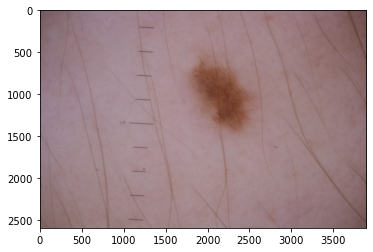

(6000, 4000)


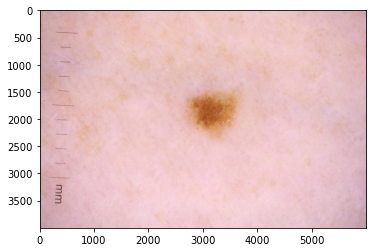

(1024, 1024)


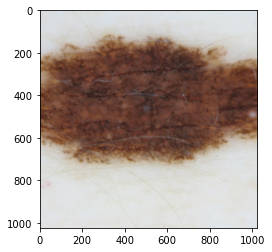

In [11]:
for df in [dftrain,dftest,df19]:
    fnm = np.random.choice(df.im_pth)
    im = Image.open(fnm)
    print(im.size)
    plt.imshow(im)
    plt.show()

(1872, 1053)

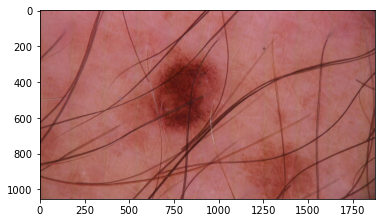

In [12]:
fnm = np.random.choice(dftrain.im_pth)
im = Image.open(fnm)
plt.imshow(im)
im.size

In [13]:
w,h=im.size
w,h

(1872, 1053)

In [14]:
def maybe_resize(im, maxsz=MAXSZ):
    w,h=im.size
    if max(w,h)<=maxsz: return im
    elif w>maxsz: 
        w_new = maxsz
        h_new = int(maxsz*h/w)
    else:
        h_new = maxsz
        w_new = int(maxsz*w/h)
    return im.resize((w_new,h_new))

(1024, 576)

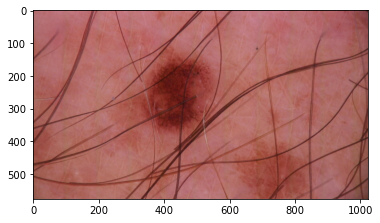

In [15]:
im_new = maybe_resize(im)
plt.imshow(im_new)
im_new.size

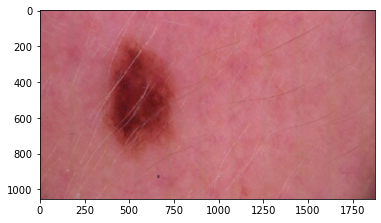

(1872, 1053)
(1024, 576)


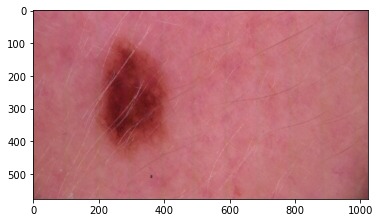

In [16]:
fnm = np.random.choice(dftrain.im_pth)
im = Image.open(fnm)
plt.imshow(im);
plt.show()
print(im.size)
im_new = maybe_resize(im)
plt.imshow(im_new)
print(im_new.size)

# run

In [17]:
def process(fnm):
    fnm_new = fnm.replace('../input', p_out)
    if os.path.exists(fnm_new): return
    im = Image.open(fnm)
    im_new = maybe_resize(im)
    im_new.save(fnm_new)

In [18]:
im_pths = np.concatenate([df.im_pth.values for df in (dftrain,dftest,df19)])
len(im_pths)

69439

In [19]:
Parallel(n_jobs=6, verbose=10)(delayed(process)(fnm) for fnm in im_pths)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    7.8s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   10.0s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   13.0s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   15.3s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   18.4s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   23.0s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   26.9s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:   30.2s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   33.6s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:   37.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   40.3s
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:   42.9s
[Parallel(

[Parallel(n_jobs=6)]: Done 9373 tasks      | elapsed: 35.3min
[Parallel(n_jobs=6)]: Done 9510 tasks      | elapsed: 35.8min
[Parallel(n_jobs=6)]: Done 9649 tasks      | elapsed: 36.3min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 36.9min
[Parallel(n_jobs=6)]: Done 9929 tasks      | elapsed: 37.4min
[Parallel(n_jobs=6)]: Done 10070 tasks      | elapsed: 37.9min
[Parallel(n_jobs=6)]: Done 10213 tasks      | elapsed: 38.5min
[Parallel(n_jobs=6)]: Done 10356 tasks      | elapsed: 39.0min
[Parallel(n_jobs=6)]: Done 10501 tasks      | elapsed: 39.6min
[Parallel(n_jobs=6)]: Done 10646 tasks      | elapsed: 40.1min
[Parallel(n_jobs=6)]: Done 10793 tasks      | elapsed: 40.6min
[Parallel(n_jobs=6)]: Done 10940 tasks      | elapsed: 41.2min
[Parallel(n_jobs=6)]: Done 11089 tasks      | elapsed: 41.8min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 42.3min
[Parallel(n_jobs=6)]: Done 11389 tasks      | elapsed: 42.9min
[Parallel(n_jobs=6)]: Done 11540 tasks      | elapsed: 43.4m

[Parallel(n_jobs=6)]: Done 35633 tasks      | elapsed: 132.0min
[Parallel(n_jobs=6)]: Done 35900 tasks      | elapsed: 132.8min
[Parallel(n_jobs=6)]: Done 36169 tasks      | elapsed: 133.7min
[Parallel(n_jobs=6)]: Done 36438 tasks      | elapsed: 134.5min
[Parallel(n_jobs=6)]: Done 36709 tasks      | elapsed: 135.4min
[Parallel(n_jobs=6)]: Done 36980 tasks      | elapsed: 136.2min
[Parallel(n_jobs=6)]: Done 37253 tasks      | elapsed: 137.0min
[Parallel(n_jobs=6)]: Done 37526 tasks      | elapsed: 137.9min
[Parallel(n_jobs=6)]: Done 37801 tasks      | elapsed: 138.7min
[Parallel(n_jobs=6)]: Done 38076 tasks      | elapsed: 139.6min
[Parallel(n_jobs=6)]: Done 38353 tasks      | elapsed: 140.4min
[Parallel(n_jobs=6)]: Done 38630 tasks      | elapsed: 141.3min
[Parallel(n_jobs=6)]: Done 38909 tasks      | elapsed: 142.1min
[Parallel(n_jobs=6)]: Done 39188 tasks      | elapsed: 142.9min
[Parallel(n_jobs=6)]: Done 39469 tasks      | elapsed: 143.9min
[Parallel(n_jobs=6)]: Done 39750 tasks  

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# inspect results

../input/siim-isic-melanoma-classification/jpeg/train/ISIC_5575449.jpg


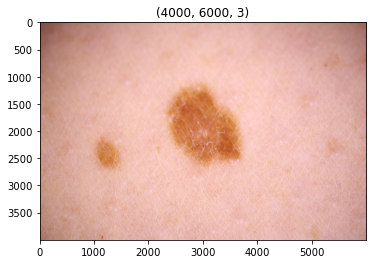

../output/MelPrp0630A1/siim-isic-melanoma-classification/jpeg/train/ISIC_5575449.jpg


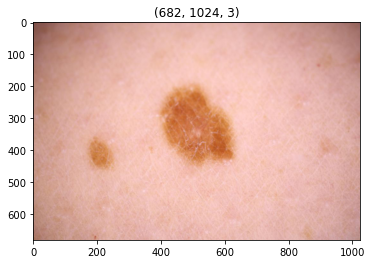

../input/siim-isic-melanoma-classification/jpeg/train/ISIC_2695497.jpg


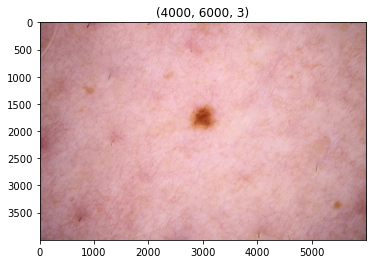

../output/MelPrp0630A1/siim-isic-melanoma-classification/jpeg/train/ISIC_2695497.jpg


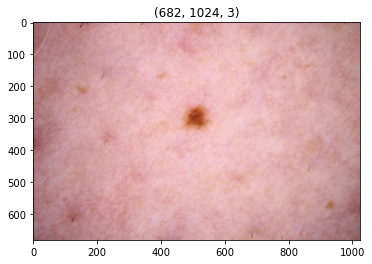

../input/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0073146.jpg


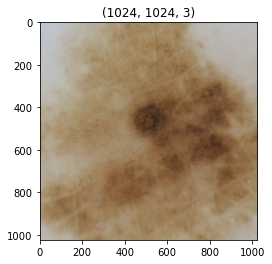

../output/MelPrp0630A1/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0073146.jpg


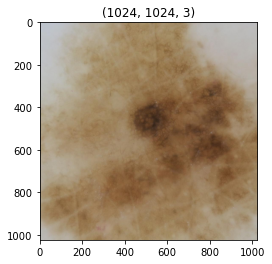

../input/siim-isic-melanoma-classification/jpeg/train/ISIC_7501061.jpg


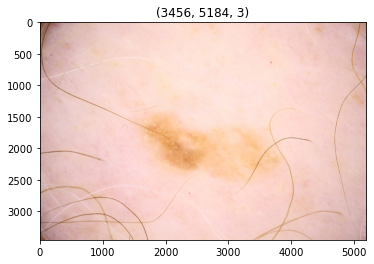

../output/MelPrp0630A1/siim-isic-melanoma-classification/jpeg/train/ISIC_7501061.jpg


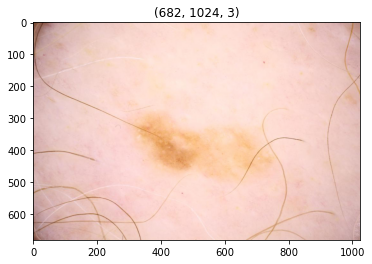

../input/siim-isic-melanoma-classification/jpeg/train/ISIC_1526547.jpg


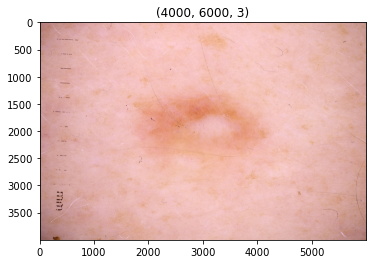

../output/MelPrp0630A1/siim-isic-melanoma-classification/jpeg/train/ISIC_1526547.jpg


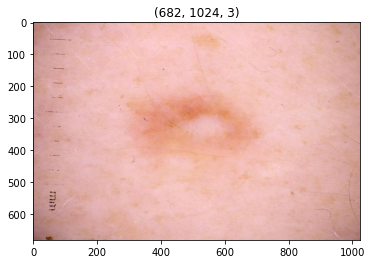

In [20]:
fnms = np.random.choice(im_pths, 5, replace=False)
for fnm in fnms:
    print(fnm)
    img = plt.imread(fnm)
    plt.title(f'{img.shape}')
    plt.imshow(img)
    plt.show()
    
    fnm_new = fnm.replace('../input', p_out)
    print(fnm_new)
    img = plt.imread(fnm_new)
    plt.title(f'{img.shape}')
    plt.imshow(img)
    plt.show()
    

# make csv

In [21]:
train,test,sample_submission = (pd.read_csv(o) for o in [f'{p_cmp}/{o}.csv' 
                                                         for o in ('train', 'test', 'sample_submission')])
print([o.shape for o in (train,test,sample_submission)])

train19 = pd.read_csv(f'{p_19}/ISIC_2019_Training_GroundTruth.csv')
train19meta = pd.read_csv(f'{p_19}/ISIC_2019_Training_Metadata.csv')

assert np.all(train19.image==train19meta.image)
train19['patient_id']=train19meta['lesion_id']

train['source'] = '20'
train['im_pth'] = f'{p_cmp}/jpeg/train/'+train.image_name+'.jpg'
train19['source'] = '19'
train19['target'] = train19.MEL
train19['im_pth'] = f'{p_19}/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'+train19.image+'.jpg'

cols2use=['source', 'im_pth', 'patient_id', 'target', ]
train_all = pd.concat([train[cols2use], train19[cols2use]])
display(train_all.shape)
display(train_all.source.value_counts())
display(train_all.groupby('source').target.mean())

test['im_pth']=f'{p_cmp}/jpeg/test/'+test.image_name+'.jpg'

[(33126, 8), (10982, 5), (10982, 2)]


(58457, 4)

20    33126
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017630
Name: target, dtype: float64

In [22]:
train_all.im_pth = train_all.im_pth.apply(lambda x: x.replace('../input', p_out))

In [23]:
test.im_pth = test.im_pth.apply(lambda x: x.replace('../input', p_out))

In [24]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0630A1/siim-isic-melanoma-clas...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0630A1/siim-isic-melanoma-clas...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0630A1/siim-isic-melanoma-clas...
3,ISIC_0073313,IP_6375035,female,50.0,torso,../output/MelPrp0630A1/siim-isic-melanoma-clas...
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,../output/MelPrp0630A1/siim-isic-melanoma-clas...


In [25]:
train_all.to_csv(f'{p_out}/train_all.csv', index=False)
test.to_csv(f'{p_out}/test.csv', index=False)